In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [55]:
import json
import re
import matplotlib.pyplot as plt

In [56]:
from deep_rl import create_action_value_dict, create_value_action_dict, create_state, available_moves
from player import Player
from hand import YatzyHand

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [58]:
lr = 0.01

In [59]:
loss_fn = F.cross_entropy

In [60]:
value_dict = create_value_action_dict(Player())
action_dict = create_action_value_dict(value_dict)

## Setting Up Data

In [61]:
inputs = []
outputs = []

def load(filename):
    with open(f'sl_data/{filename}', 'r') as file:
        data = json.load(file)

    for key, value in data.items():
        state = re.findall(f'\d+', key)
        state = [float(x) for x in state]
        state = torch.tensor(state, device=device)
        inputs.append(state)

        move = action_dict[value]
        outputs.append(torch.tensor(move, device=device))

load('10.3_data.json')

In [62]:
input_tensor = torch.stack(inputs)
output_tensor = torch.stack(outputs)

In [63]:
train_ds = TensorDataset(input_tensor, output_tensor)

In [64]:
len(train_ds)

72950

In [65]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

## Helper Functions

In [66]:
def plot_averages(averages, title):
    plt.plot(range(len(averages)), averages)
    plt.xlabel('Epoch')
    plt.ylabel('Average score')
    plt.title(title)
    plt.ylim([0, 374])


In [67]:
def nospace(str):
    return ''.join([char for char in str if not char.isspace()])

## Model

In [68]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=0)
        self.layer1 = nn.Linear(20, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 46)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.softmax(self.layer3(x))

In [69]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=0)
        self.layer1 = nn.Linear(20, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 46)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.softmax(self.layer6(x))

## Evaluation

In [70]:
class EvalGame():
    def __init__(self, player, num):
        self.player = player
        self.scores = []
        self.num = num
    
    
    def evaluate(self):
        player = self.player

        for i in range(self.num):
            player.reset_scoresheet()

            turns = 0
            while turns < 15:
                self.turn(player)
                turns += 1
            
            score = player.calculate_score()
            self.scores.append(score)

    def turn(self, player):
        hand = YatzyHand()

        rerolls = 0
        while rerolls < 2:

            move = player.choose_move(hand, reroll=True)

            if move >= 15:
                rerolls += 1
                indices = player.get_indices(move)

                hand = hand.reroll(indices)
            else:
                break

        move = player.choose_move(hand, reroll=False)

        action = value_dict[move]

        score = getattr(hand, action)()

        player.update_scoresheet(action, score)
        
    def results(self):
        return sum(self.scores) / len(self.scores)

In [83]:
class EvalBot(Player):
    def __init__(self):
        super().__init__()
        self.model = Model_1()
    
    def load(self, state_dict):
        self.model.load_state_dict(state_dict)
        self.model.eval()

    def get_indices(self, action):
        temp = re.findall(f'\d', value_dict[action])
        return [int(x) for x in temp]
        
    def available_moves(self, reroll=False):
        final = []
        i = 0
        for key, value in self.scoresheet.items():
            if value == None:
                final.append(i)
            i += 1
        
        if reroll:
            for i in range(15, 46):
                final.append(i)
                i += 1
                
        return torch.tensor(final)


    
    def choose_move(self, hand, reroll=False):
        state = create_state(self.scoresheet, hand)
        options = self.available_moves(reroll=reroll)

        with torch.no_grad():
            
            available_mask = torch.tensor(tuple(map(lambda x: x not in options, range(46))), device=device, dtype=torch.bool)
            
            results = model(state)
            results[available_mask] = 0
            
            return torch.argmax(results).view(1).item()
            

In [84]:
def evaluate(num, state_dict):
    # evaluates a model by having it play num games; pass in the state_dicts
    #returns the average score over those games
    
    player = EvalBot()
    player.load(state_dict)

    game = EvalGame(player, num)

    game.evaluate()

    return game.results()

## Training

In [85]:
def get_model():
    model = Model_1()
    opt = optim.SGD(model.parameters(), lr = lr)
    return model, opt

In [86]:
def train(epochs, gen):
    averages = []

    start_avg = evaluate(100, model.state_dict())
    print('Starting average: {}'.format(start_avg))
    
    for i in range(epochs):
        
        for x, y in train_dl:
            preds = model(x)
            loss = loss_fn(preds, y)

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        print('Epoch {} done'.format(i))
        avg = evaluate(100, model.state_dict())
        print('Average score: {}'.format(avg))
        averages.append(avg)

        torch.save(model.state_dict(), 'sl_models/gen_{}.pt'.format(gen))
    
    plot_averages(averages, 'Gen {} - 75k Datapoints (Filtered), 3 Layers, Shuffled Data'.format(gen))

    
        

In [87]:
model, opt = get_model()


Starting average: 43.24
Epoch 0 done
Average score: 38.52
Epoch 1 done
Average score: 47.66
Epoch 2 done
Average score: 45.77
Epoch 3 done
Average score: 47.63
Epoch 4 done
Average score: 47.57
Epoch 5 done
Average score: 53.84
Epoch 6 done
Average score: 54.71
Epoch 7 done
Average score: 62.93
Epoch 8 done
Average score: 58.61
Epoch 9 done
Average score: 62.15
Epoch 10 done
Average score: 66.04
Epoch 11 done
Average score: 62.3
Epoch 12 done
Average score: 61.75
Epoch 13 done
Average score: 67.82
Epoch 14 done
Average score: 69.54
Epoch 15 done
Average score: 74.94
Epoch 16 done
Average score: 72.7
Epoch 17 done
Average score: 69.41
Epoch 18 done
Average score: 71.64
Epoch 19 done
Average score: 72.01
Epoch 20 done
Average score: 73.9
Epoch 21 done
Average score: 70.85
Epoch 22 done
Average score: 73.7
Epoch 23 done
Average score: 73.49
Epoch 24 done
Average score: 75.39
Epoch 25 done
Average score: 75.54
Epoch 26 done
Average score: 73.87
Epoch 27 done
Average score: 81.3
Epoch 28 do

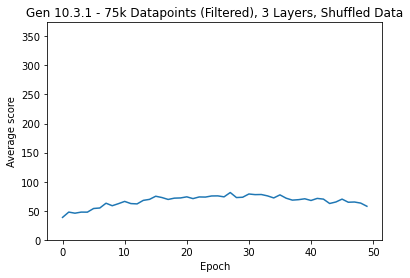

In [88]:
train(50, '10.3.1')